In [11]:
import sys, os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
sys.path.append(os.path.abspath(os.path.join('../../../BayesFlow')))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from functools import partial
import pickle

import tensorflow as tf

In [12]:
from bayesflow import benchmarks
from bayesflow.amortizers import AmortizedPosterior, AmortizedLikelihood, AmortizedPosteriorLikelihood
from bayesflow.networks import InvertibleNetwork
from bayesflow.trainers import Trainer
from bayesflow.diagnostics import plot_sbc_ecdf, plot_recovery, plot_posterior_2d, plot_losses, plot_latent_space_2d

In [13]:
from tensorflow_probability import distributions as tfd

In [14]:
benchmark_name = 'lotka_volterra'
benchmark = benchmarks.Benchmark(benchmark_name)

INFO:root:Performing 2 pilot runs with the lotka_volterra model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 4)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 20)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


# Amortizer and Trainer
Note, do not try this at home! :)

The LV likelihood generates nearly-deterministic time series, so it should be modeled with a recurrent likelihood. However, we stick to the original formulation in Lueckmann et al. (2021), which uses data at 20 uniformly sampled time points and treats it as a 20-dimensional vector instead of a time series of 20 scalars.

In [139]:
# No summary net, mock
summary_net = lambda x, **kwargs: x

# Robust inference with a Student-T latent
latent_dist_p = tfd.MultivariateStudentTLinearOperator(
    df=50, loc=[0.]*4, scale=tf.linalg.LinearOperatorDiag([1.]*4))
latent_dist_l = tfd.MultivariateStudentTLinearOperator(
    df=50, loc=[0.]*20, scale=tf.linalg.LinearOperatorDiag([1.]*20))


coupling_settings = {
    'affine': {
        'dense_args': dict(units=128, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        'dropout_prob': 0.05
    },
    'spline': {
        'dense_args': dict(units=128, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        'dropout_prob': 0.05
    }
}

# Inference networks
inference_net_p = InvertibleNetwork(
    num_params=4, 
    num_coupling_layers=6,
    coupling_design='interleaved',
    coupling_settings=coupling_settings
)

inference_net_l = InvertibleNetwork(
    num_params=20, 
    num_coupling_layers=8,
    coupling_design='interleaved',
    coupling_settings=coupling_settings,
)

# Amortizers
amortized_posterior = AmortizedPosterior(
    inference_net=inference_net_p,
    summary_net=summary_net,
    latent_dist=latent_dist_p
)

amortized_likelihood = AmortizedLikelihood(
    surrogate_net=inference_net_l,
    latent_dist=latent_dist_l
)

amortizer = AmortizedPosteriorLikelihood(
    amortized_posterior, 
    amortized_likelihood
)

In [140]:
trainer = Trainer(
    amortizer=amortizer,
    default_lr=1e-3,
    generative_model=benchmark.generative_model,
    configurator=partial(benchmark.configurator, as_summary_condition=True),
    checkpoint_path=f'checkpoints/{benchmark_name}',
    memory=False   
)

INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


# Training
Uncomment for training. Wall time on GPU: 32min 6s

In [141]:
EPOCHS = 150
SIMULATION_BUDGET = 10000
N_VAL = 300
BATCH_SIZE = 64

train_data = trainer.generative_model(SIMULATION_BUDGET)

In [143]:
%%time
h = trainer.train_offline(train_data, EPOCHS, BATCH_SIZE, validation_sims=N_VAL)

INFO:root:Generated 300 simulations for validation.


Training epoch 1:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Post.Loss: -4.865, Lik.Loss: -66.051


Training epoch 2:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Post.Loss: -5.468, Lik.Loss: -71.664


Training epoch 3:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Post.Loss: -6.203, Lik.Loss: -74.068


Training epoch 4:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Post.Loss: -5.938, Lik.Loss: -78.009


Training epoch 5:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Post.Loss: -6.282, Lik.Loss: -78.985


Training epoch 6:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Post.Loss: -7.301, Lik.Loss: -82.378


Training epoch 7:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Post.Loss: -7.446, Lik.Loss: -85.307


Training epoch 8:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, Post.Loss: -7.671, Lik.Loss: -83.083


Training epoch 9:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, Post.Loss: -7.296, Lik.Loss: -86.308


Training epoch 10:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, Post.Loss: -8.161, Lik.Loss: -86.954


Training epoch 11:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 11, Post.Loss: -7.942, Lik.Loss: -87.234


Training epoch 12:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 12, Post.Loss: -7.901, Lik.Loss: -87.607


Training epoch 13:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 13, Post.Loss: -8.236, Lik.Loss: -88.901


Training epoch 14:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 14, Post.Loss: -8.452, Lik.Loss: -87.791


Training epoch 15:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 15, Post.Loss: -8.751, Lik.Loss: -89.819


Training epoch 16:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 16, Post.Loss: -7.778, Lik.Loss: -90.073


Training epoch 17:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 17, Post.Loss: -8.527, Lik.Loss: -91.348


Training epoch 18:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 18, Post.Loss: -9.035, Lik.Loss: -92.072


Training epoch 19:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 19, Post.Loss: -8.561, Lik.Loss: -91.581


Training epoch 20:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 20, Post.Loss: -8.671, Lik.Loss: -90.830


Training epoch 21:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 21, Post.Loss: -8.726, Lik.Loss: -91.889


Training epoch 22:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 22, Post.Loss: -8.966, Lik.Loss: -91.207


Training epoch 23:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 23, Post.Loss: -9.434, Lik.Loss: -91.297


Training epoch 24:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 24, Post.Loss: -9.374, Lik.Loss: -93.974


Training epoch 25:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 25, Post.Loss: -9.239, Lik.Loss: -93.124


Training epoch 26:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 26, Post.Loss: -9.180, Lik.Loss: -92.280


Training epoch 27:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 27, Post.Loss: -9.666, Lik.Loss: -93.391


Training epoch 28:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 28, Post.Loss: -9.422, Lik.Loss: -96.037


Training epoch 29:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 29, Post.Loss: -9.581, Lik.Loss: -94.421


Training epoch 30:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 30, Post.Loss: -9.708, Lik.Loss: -95.994


Training epoch 31:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 31, Post.Loss: -9.714, Lik.Loss: -94.998


Training epoch 32:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 32, Post.Loss: -9.824, Lik.Loss: -96.526


Training epoch 33:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 33, Post.Loss: -9.988, Lik.Loss: -94.147


Training epoch 34:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 34, Post.Loss: -9.873, Lik.Loss: -95.118


Training epoch 35:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 35, Post.Loss: -9.929, Lik.Loss: -95.438


Training epoch 36:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 36, Post.Loss: -9.762, Lik.Loss: -97.126


Training epoch 37:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 37, Post.Loss: -9.231, Lik.Loss: -96.423


Training epoch 38:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 38, Post.Loss: -10.257, Lik.Loss: -96.922


Training epoch 39:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 39, Post.Loss: -9.899, Lik.Loss: -95.236


Training epoch 40:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 40, Post.Loss: -10.027, Lik.Loss: -96.993


Training epoch 41:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 41, Post.Loss: -9.070, Lik.Loss: -95.941


Training epoch 42:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 42, Post.Loss: -9.791, Lik.Loss: -98.266


Training epoch 43:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 43, Post.Loss: -10.237, Lik.Loss: -98.207


Training epoch 44:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 44, Post.Loss: -9.635, Lik.Loss: -98.951


Training epoch 45:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 45, Post.Loss: -10.269, Lik.Loss: -98.299


Training epoch 46:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 46, Post.Loss: -10.411, Lik.Loss: -98.943


Training epoch 47:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 47, Post.Loss: -10.431, Lik.Loss: -97.086


Training epoch 48:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 48, Post.Loss: -10.253, Lik.Loss: -98.539


Training epoch 49:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 49, Post.Loss: -10.748, Lik.Loss: -99.170


Training epoch 50:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 50, Post.Loss: -10.404, Lik.Loss: -99.928


Training epoch 51:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 51, Post.Loss: -9.992, Lik.Loss: -98.997


Training epoch 52:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 52, Post.Loss: -10.348, Lik.Loss: -101.085


Training epoch 53:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 53, Post.Loss: -9.968, Lik.Loss: -100.142


Training epoch 54:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 54, Post.Loss: -10.525, Lik.Loss: -100.266


Training epoch 55:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 55, Post.Loss: -10.385, Lik.Loss: -99.957


Training epoch 56:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 56, Post.Loss: -10.574, Lik.Loss: -99.670


Training epoch 57:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 57, Post.Loss: -10.636, Lik.Loss: -99.516


Training epoch 58:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 58, Post.Loss: -10.669, Lik.Loss: -99.796


Training epoch 59:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 59, Post.Loss: -10.783, Lik.Loss: -100.965


Training epoch 60:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 60, Post.Loss: -10.897, Lik.Loss: -99.059


Training epoch 61:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 61, Post.Loss: -10.819, Lik.Loss: -100.064


Training epoch 62:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 62, Post.Loss: -10.599, Lik.Loss: -101.365


Training epoch 63:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 63, Post.Loss: -10.749, Lik.Loss: -102.252


Training epoch 64:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 64, Post.Loss: -10.446, Lik.Loss: -101.835


Training epoch 65:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 65, Post.Loss: -11.026, Lik.Loss: -102.117


Training epoch 66:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 66, Post.Loss: -10.726, Lik.Loss: -101.575


Training epoch 67:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 67, Post.Loss: -11.021, Lik.Loss: -101.644


Training epoch 68:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 68, Post.Loss: -10.651, Lik.Loss: -101.224


Training epoch 69:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 69, Post.Loss: -11.067, Lik.Loss: -102.583


Training epoch 70:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 70, Post.Loss: -11.010, Lik.Loss: -100.970


Training epoch 71:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 71, Post.Loss: -11.024, Lik.Loss: -102.024


Training epoch 72:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 72, Post.Loss: -11.120, Lik.Loss: -101.554


Training epoch 73:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 73, Post.Loss: -10.917, Lik.Loss: -102.204


Training epoch 74:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 74, Post.Loss: -10.848, Lik.Loss: -102.381


Training epoch 75:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 75, Post.Loss: -10.987, Lik.Loss: -102.269


Training epoch 76:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 76, Post.Loss: -10.960, Lik.Loss: -102.474


Training epoch 77:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 77, Post.Loss: -11.258, Lik.Loss: -103.754


Training epoch 78:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 78, Post.Loss: -11.207, Lik.Loss: -102.940


Training epoch 79:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 79, Post.Loss: -11.095, Lik.Loss: -102.952


Training epoch 80:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 80, Post.Loss: -11.197, Lik.Loss: -103.147


Training epoch 81:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 81, Post.Loss: -11.142, Lik.Loss: -103.566


Training epoch 82:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 82, Post.Loss: -11.107, Lik.Loss: -102.971


Training epoch 83:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 83, Post.Loss: -11.326, Lik.Loss: -103.448


Training epoch 84:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 84, Post.Loss: -11.213, Lik.Loss: -103.354


Training epoch 85:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 85, Post.Loss: -11.090, Lik.Loss: -104.452


Training epoch 86:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 86, Post.Loss: -11.355, Lik.Loss: -104.441


Training epoch 87:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 87, Post.Loss: -11.013, Lik.Loss: -104.605


Training epoch 88:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 88, Post.Loss: -11.395, Lik.Loss: -104.403


Training epoch 89:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 89, Post.Loss: -11.300, Lik.Loss: -104.925


Training epoch 90:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 90, Post.Loss: -11.167, Lik.Loss: -104.587


Training epoch 91:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 91, Post.Loss: -11.468, Lik.Loss: -104.291


Training epoch 92:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 92, Post.Loss: -11.459, Lik.Loss: -104.637


Training epoch 93:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 93, Post.Loss: -11.379, Lik.Loss: -104.691


Training epoch 94:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 94, Post.Loss: -11.439, Lik.Loss: -103.853


Training epoch 95:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 95, Post.Loss: -11.351, Lik.Loss: -104.817


Training epoch 96:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 96, Post.Loss: -11.173, Lik.Loss: -104.409


Training epoch 97:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 97, Post.Loss: -11.402, Lik.Loss: -105.927


Training epoch 98:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 98, Post.Loss: -11.588, Lik.Loss: -105.610


Training epoch 99:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 99, Post.Loss: -11.531, Lik.Loss: -105.208


Training epoch 100:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 100, Post.Loss: -11.487, Lik.Loss: -105.855


Training epoch 101:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 101, Post.Loss: -11.505, Lik.Loss: -105.768


Training epoch 102:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 102, Post.Loss: -11.594, Lik.Loss: -105.202


Training epoch 103:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 103, Post.Loss: -11.579, Lik.Loss: -105.117


Training epoch 104:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 104, Post.Loss: -11.637, Lik.Loss: -105.969


Training epoch 105:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 105, Post.Loss: -11.308, Lik.Loss: -106.141


Training epoch 106:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 106, Post.Loss: -11.583, Lik.Loss: -105.998


Training epoch 107:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 107, Post.Loss: -11.358, Lik.Loss: -105.715


Training epoch 108:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 108, Post.Loss: -11.646, Lik.Loss: -106.422


Training epoch 109:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 109, Post.Loss: -11.817, Lik.Loss: -106.563


Training epoch 110:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 110, Post.Loss: -11.817, Lik.Loss: -106.165


Training epoch 111:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 111, Post.Loss: -11.702, Lik.Loss: -106.500


Training epoch 112:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 112, Post.Loss: -11.619, Lik.Loss: -106.505


Training epoch 113:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 113, Post.Loss: -11.802, Lik.Loss: -106.374


Training epoch 114:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 114, Post.Loss: -11.620, Lik.Loss: -106.377


Training epoch 115:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 115, Post.Loss: -11.820, Lik.Loss: -106.829


Training epoch 116:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 116, Post.Loss: -11.865, Lik.Loss: -107.099


Training epoch 117:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 117, Post.Loss: -11.463, Lik.Loss: -106.536


Training epoch 118:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 118, Post.Loss: -11.815, Lik.Loss: -106.747


Training epoch 119:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 119, Post.Loss: -11.902, Lik.Loss: -106.919


Training epoch 120:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 120, Post.Loss: -11.874, Lik.Loss: -107.256


Training epoch 121:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 121, Post.Loss: -11.785, Lik.Loss: -107.111


Training epoch 122:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 122, Post.Loss: -11.865, Lik.Loss: -106.899


Training epoch 123:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 123, Post.Loss: -11.871, Lik.Loss: -107.256


Training epoch 124:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 124, Post.Loss: -11.874, Lik.Loss: -107.223


Training epoch 125:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 125, Post.Loss: -11.933, Lik.Loss: -107.257


Training epoch 126:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 126, Post.Loss: -11.969, Lik.Loss: -107.465


Training epoch 127:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 127, Post.Loss: -11.982, Lik.Loss: -107.417


Training epoch 128:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 128, Post.Loss: -11.960, Lik.Loss: -107.343


Training epoch 129:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 129, Post.Loss: -11.924, Lik.Loss: -107.502


Training epoch 130:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 130, Post.Loss: -11.990, Lik.Loss: -107.448


Training epoch 131:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 131, Post.Loss: -11.998, Lik.Loss: -107.561


Training epoch 132:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 132, Post.Loss: -11.996, Lik.Loss: -107.572


Training epoch 133:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 133, Post.Loss: -11.993, Lik.Loss: -107.561


Training epoch 134:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 134, Post.Loss: -12.012, Lik.Loss: -107.632


Training epoch 135:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 135, Post.Loss: -12.015, Lik.Loss: -107.664


Training epoch 136:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 136, Post.Loss: -12.022, Lik.Loss: -107.648


Training epoch 137:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 137, Post.Loss: -12.031, Lik.Loss: -107.731


Training epoch 138:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 138, Post.Loss: -12.034, Lik.Loss: -107.733


Training epoch 139:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 139, Post.Loss: -12.023, Lik.Loss: -107.780


Training epoch 140:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 140, Post.Loss: -12.033, Lik.Loss: -107.804


Training epoch 141:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 141, Post.Loss: -12.051, Lik.Loss: -107.855


Training epoch 142:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 142, Post.Loss: -12.046, Lik.Loss: -107.825


Training epoch 143:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 143, Post.Loss: -12.039, Lik.Loss: -107.837


Training epoch 144:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 144, Post.Loss: -12.051, Lik.Loss: -107.862


Training epoch 145:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 145, Post.Loss: -12.045, Lik.Loss: -107.852


Training epoch 146:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 146, Post.Loss: -12.044, Lik.Loss: -107.890


Training epoch 147:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 147, Post.Loss: -12.048, Lik.Loss: -107.897


Training epoch 148:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 148, Post.Loss: -12.049, Lik.Loss: -107.903


Training epoch 149:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 149, Post.Loss: -12.051, Lik.Loss: -107.902


Training epoch 150:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 150, Post.Loss: -12.051, Lik.Loss: -107.901


CPU times: user 59min 27s, sys: 10min 34s, total: 1h 10min 1s
Wall time: 40min 37s


# Validation

## Loss Trajectories

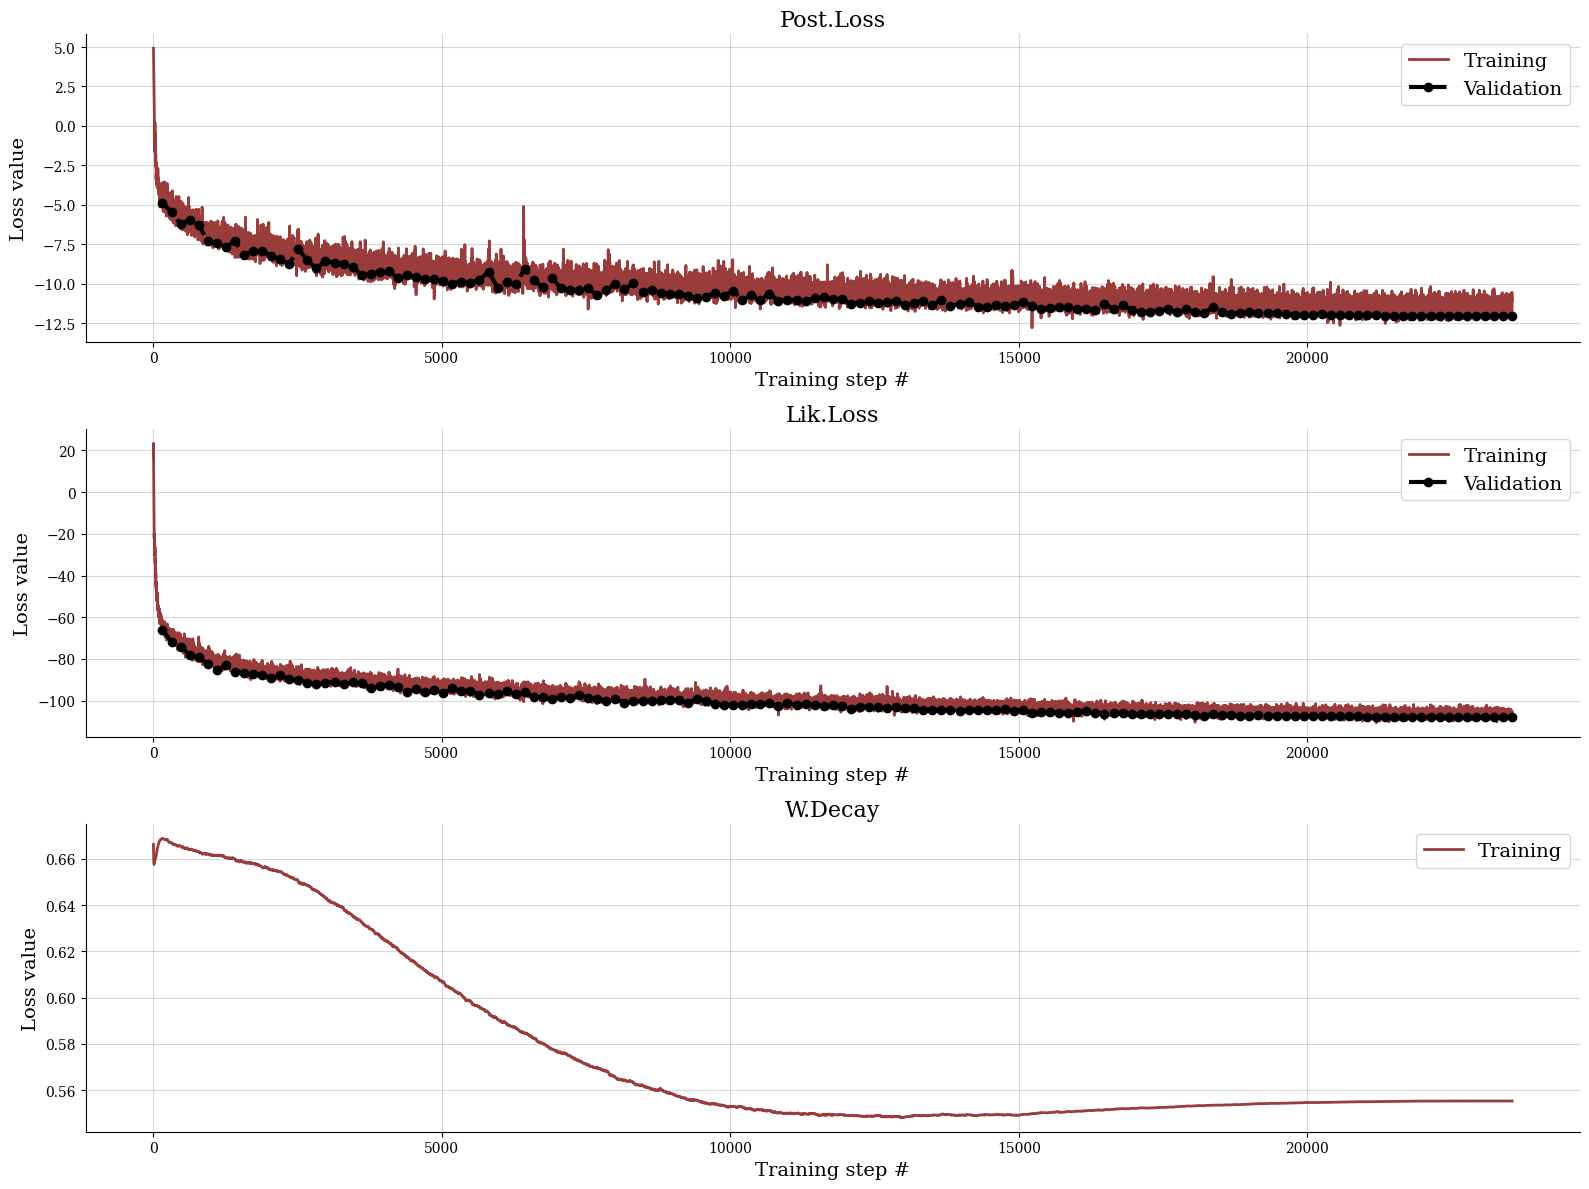

In [144]:
# Use loaded history, since reference 'h' will only exist after training
h = trainer.loss_history.get_plottable()
f = plot_losses(h['train_losses'], h['val_losses'])

## Test (Held-Out) Data

In [155]:
# Load test data
with open(f'test_data/{benchmark_name}_test.pkl', 'rb') as f:
    test_dict = pickle.load(f)

In [ ]:
test_dict = trainer.con

In [156]:
# Simulate from surrogate simulator
x_sim_s = amortizer.sample_data(test_dict, n_samples=1)
x_sim_s = tf.squeeze(x_sim_s)

# Sample from posteriors given surrogate outputs
post_samples_s = amortizer.sample_parameters({'summary_conditions': x_sim_s}, n_samples=250)

# Sample from posteriors given simulator outputs
post_samples = amortizer.sample_parameters(test_dict, n_samples=250)

# Prior samples
prior_samples = test_dict['posterior_inputs']['parameters']

### Calibration

#### ECDF Difference (Stacked)

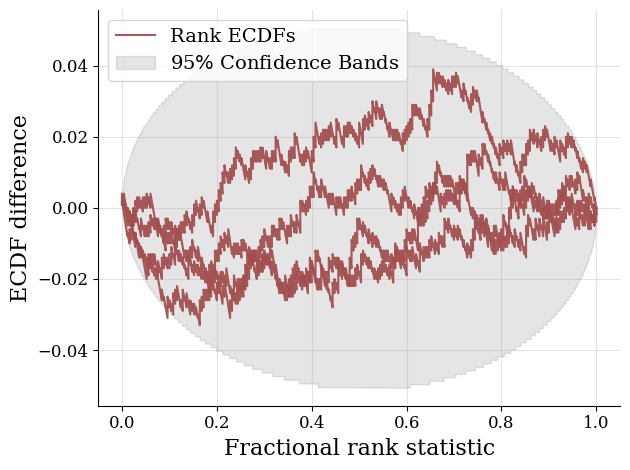

In [157]:
# Posterior given simulator outputs
f = plot_sbc_ecdf(post_samples, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95), stacked=True, difference=True)

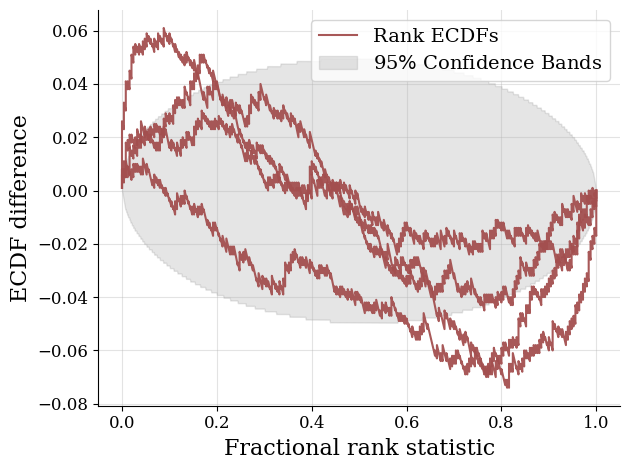

In [158]:
# Posterior given surrogate outputs
f = plot_sbc_ecdf(post_samples_s, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95), stacked=True, difference=True)

#### Individual ECDF Plots

### Recovery

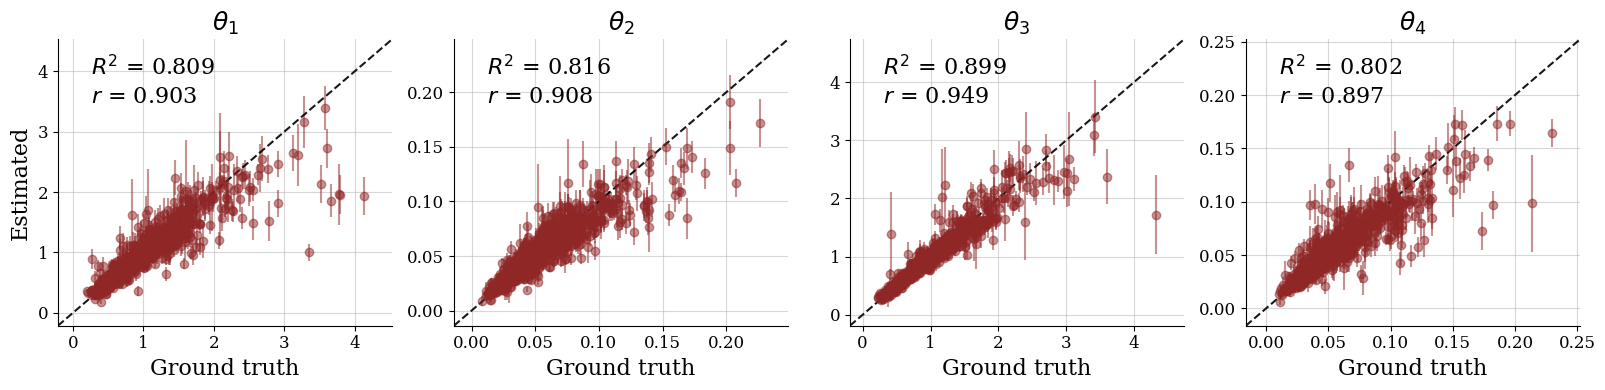

In [159]:
f = plot_recovery(post_samples, prior_samples)

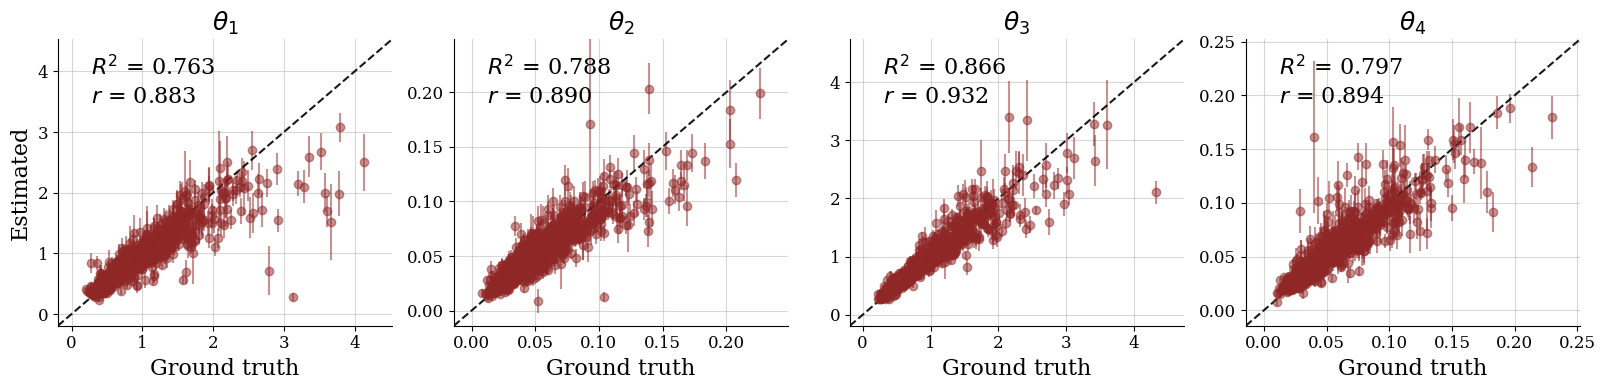

In [160]:
f = plot_recovery(post_samples_s, prior_samples)

# Appendix Plots

In [161]:
# load custom tighter plotting function
from custom_plots import plot_sbc_ecdf_appendix

# adjust for better readability
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    'text.latex.preamble' : r'\usepackage{{amsmath}}'
})

### Loss History

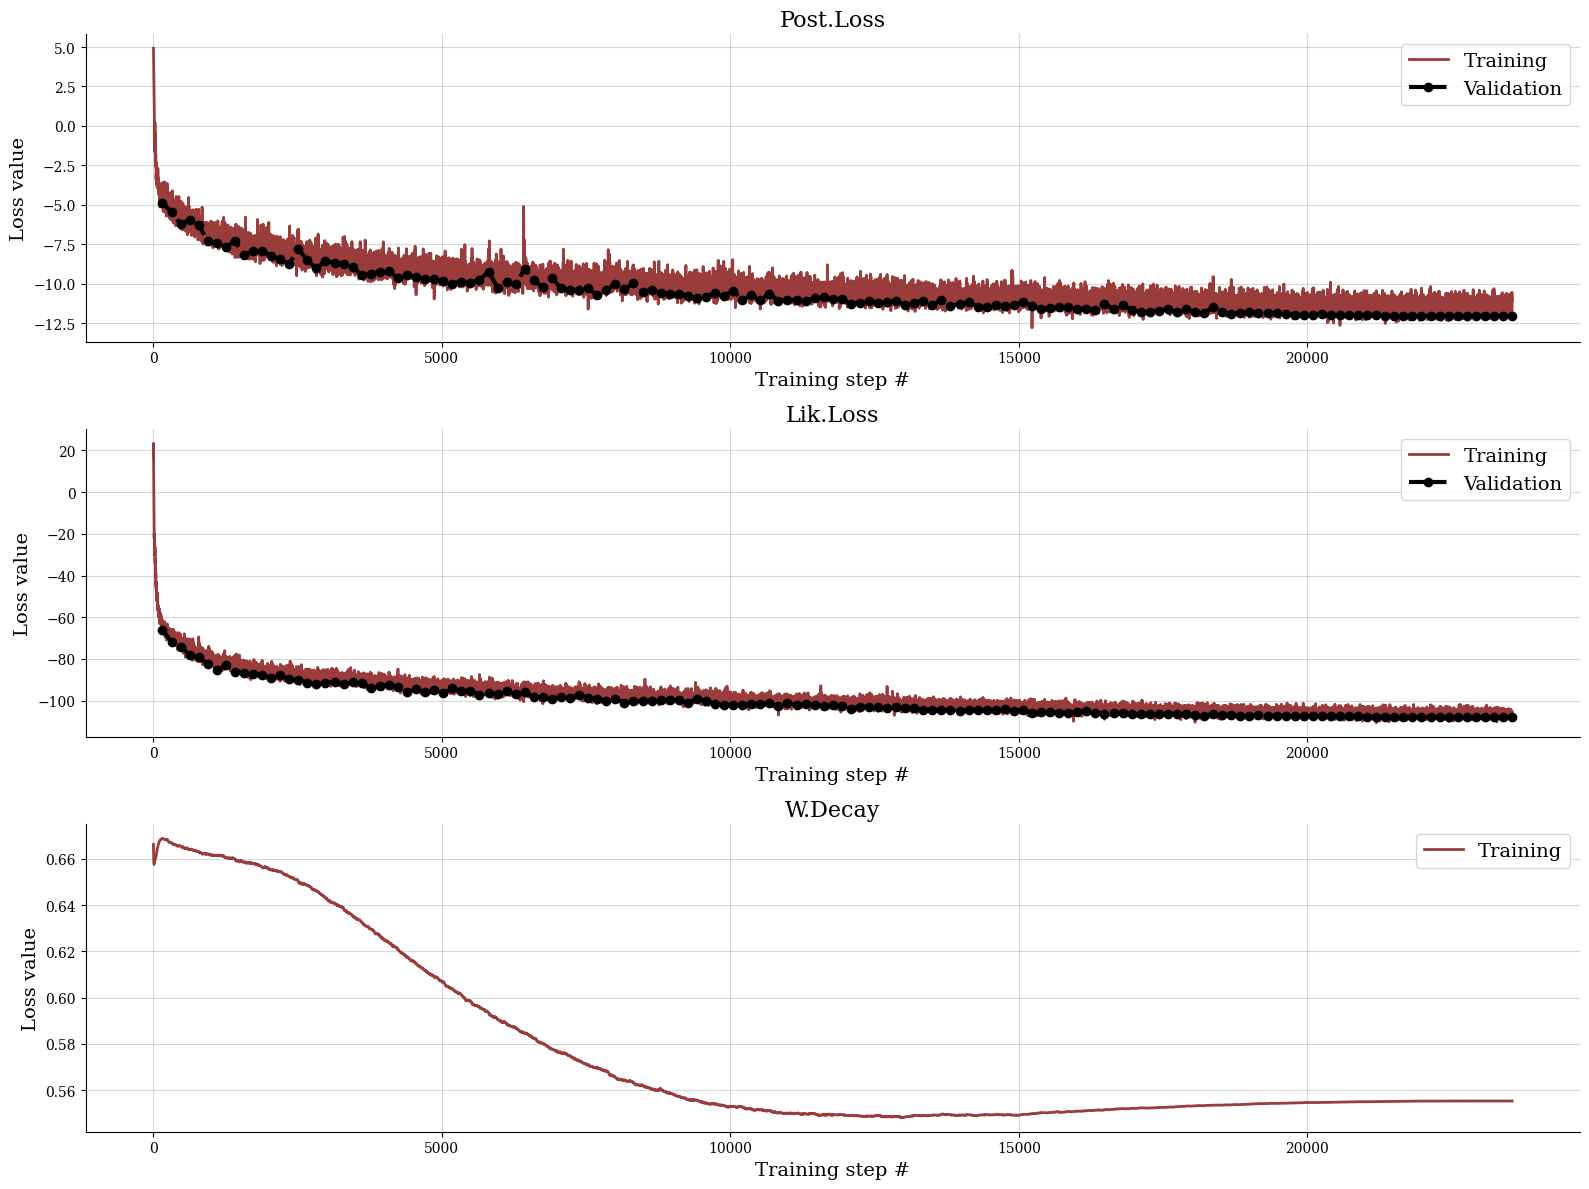

In [162]:
# Use loaded history, since reference 'h' will only exist after training
h = trainer.loss_history.get_plottable()
f = plot_losses(h['train_losses'], h['val_losses'])
plt.savefig(f"figures/{benchmark_name}_losses.pdf", dpi=300, bbox_inches="tight")

### Posterior Calibration

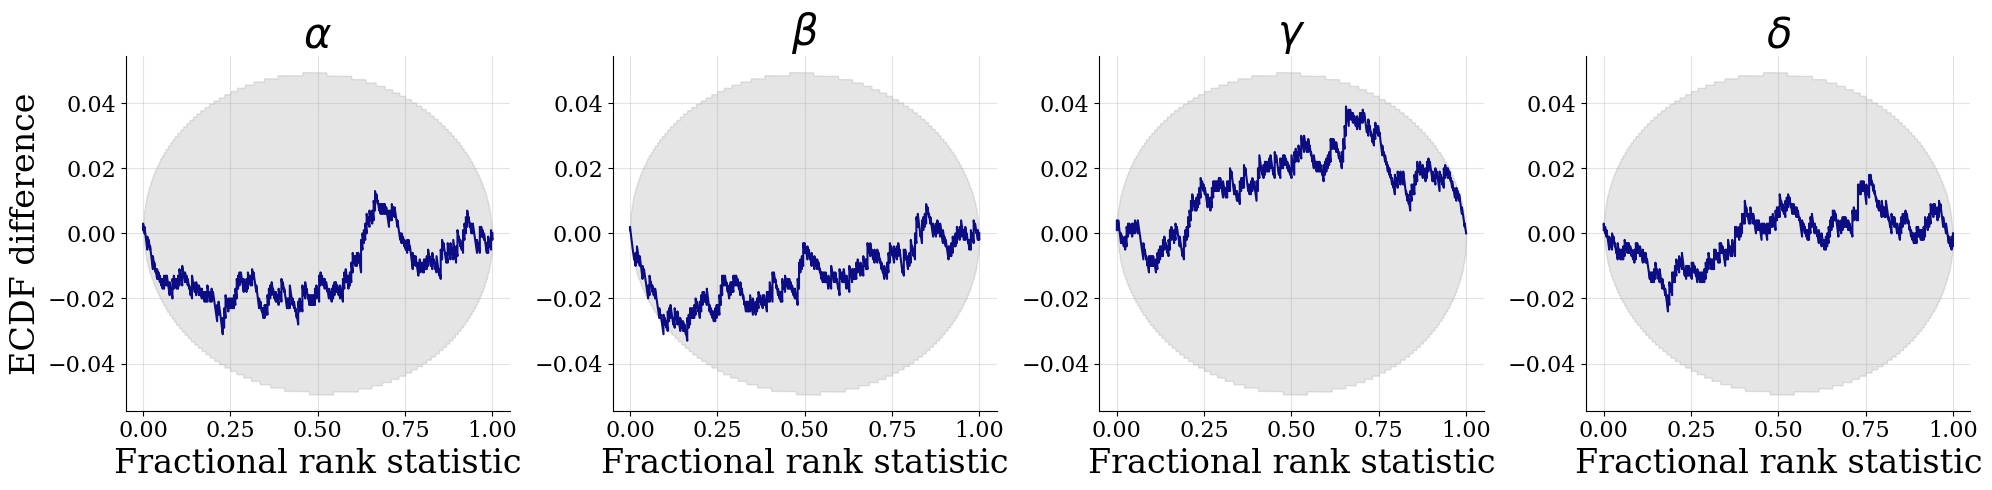

In [163]:
f = plot_sbc_ecdf_appendix(post_samples, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95), 
                           param_names = benchmark.benchmark_info['parameter_names'],
                           label_fontsize=24, legend_fontsize=24, difference=True, rank_ecdf_color = '#000080' )
plt.savefig(f"figures/{benchmark_name}_posterior_calibration_diff_separate.pdf", dpi = 300, bbox_inches = "tight")

### Joint Calibration

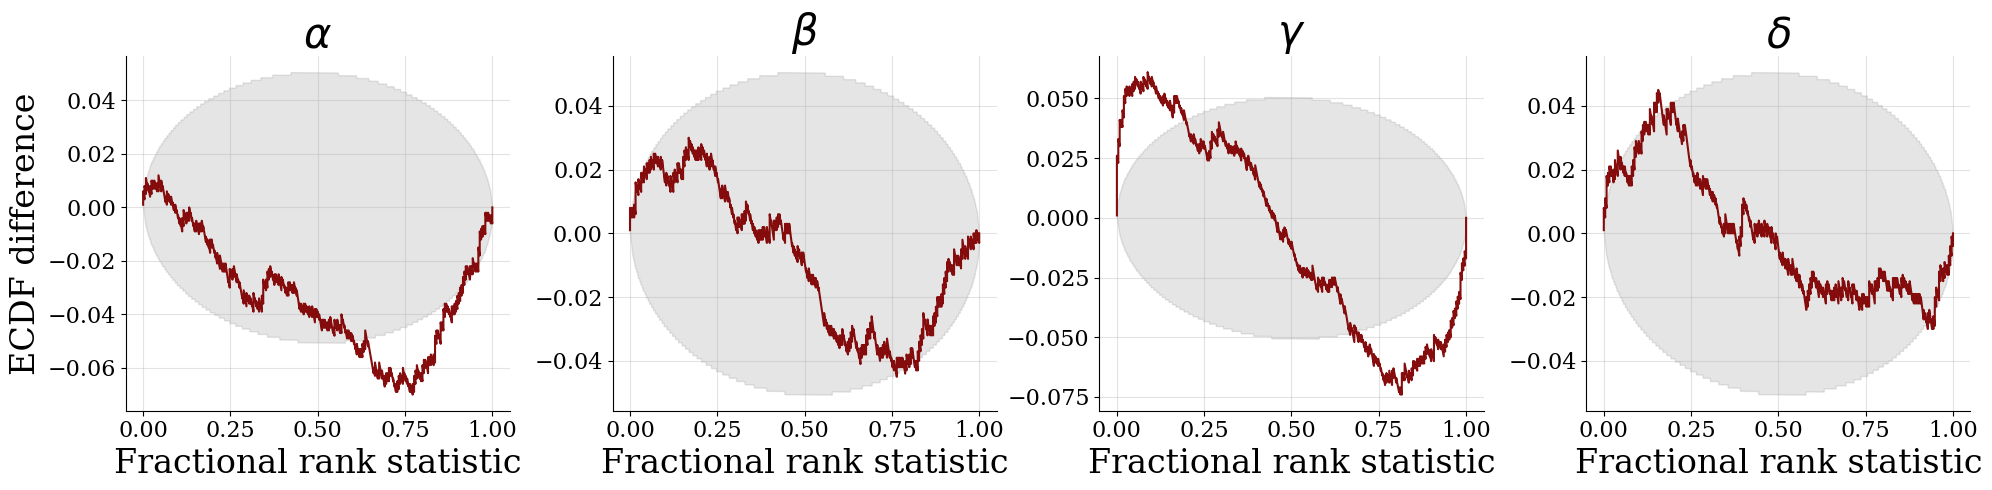

In [164]:
f = plot_sbc_ecdf_appendix(post_samples_s, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95), 
                           param_names = benchmark.benchmark_info['parameter_names'],
                           label_fontsize=24, legend_fontsize=24, difference=True, rank_ecdf_color = '#800000')
plt.savefig(f"figures/{benchmark_name}_joint_calibration_diff_separate.pdf", dpi = 300, bbox_inches = "tight")